In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import matplotlib.image as mpimg
import glob
%matplotlib inline

calibrationDir=r'C:\Users\Siddarth\Desktop\Udacity\CarND-Advanced-Lane-Lines-master\camera_cal\calibration*.jpg'

## CRITERIA 1: Provide a Writeup / README that includes all the rubric points and how you addressed each one. You can submit your writeup as markdown or pdf. Here is a template writeup for this project you can use as a guide and a starting point.

## ANSWER: All writeup is provided in the current Notebook

## **CRITERIA 2**: Briefly state how you computed the camera matrix and distortion coefficients. Provide an example of a distortion corrected calibration image.
## **ANSWER** : The calibration Matrix was calculated by the method discussed in the lessons. The chess board here has 9x6 corners and this has been accounted for.

Below is also a Image of distorted calibration image and undistorted calibration image.

In [3]:
def CalibrationMatrix():
    images =glob.glob(calibrationDir)
    objpoints=[]
    imgpoints=[]
    for image in images:
        img=plt.imread(image)
        ### 9x6 Corners
        objp=np.zeros((6*9,3),np.float32)
        objp[:,:2]=np.mgrid[0:9,0:6].T.reshape(-1,2)

        gray=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

        ret,corners= cv2.findChessboardCorners(gray,(9,6),None)
        if ret ==True:
            imgpoints.append(corners)
            objpoints.append(objp)
    ## retval, cameraMatrix, distortion Coeffs, rotation vector, translation vector
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    return mtx,dist

# declaring global values to so it they can also be called later

global mtx
global dist

mtx,dist= CalibrationMatrix()

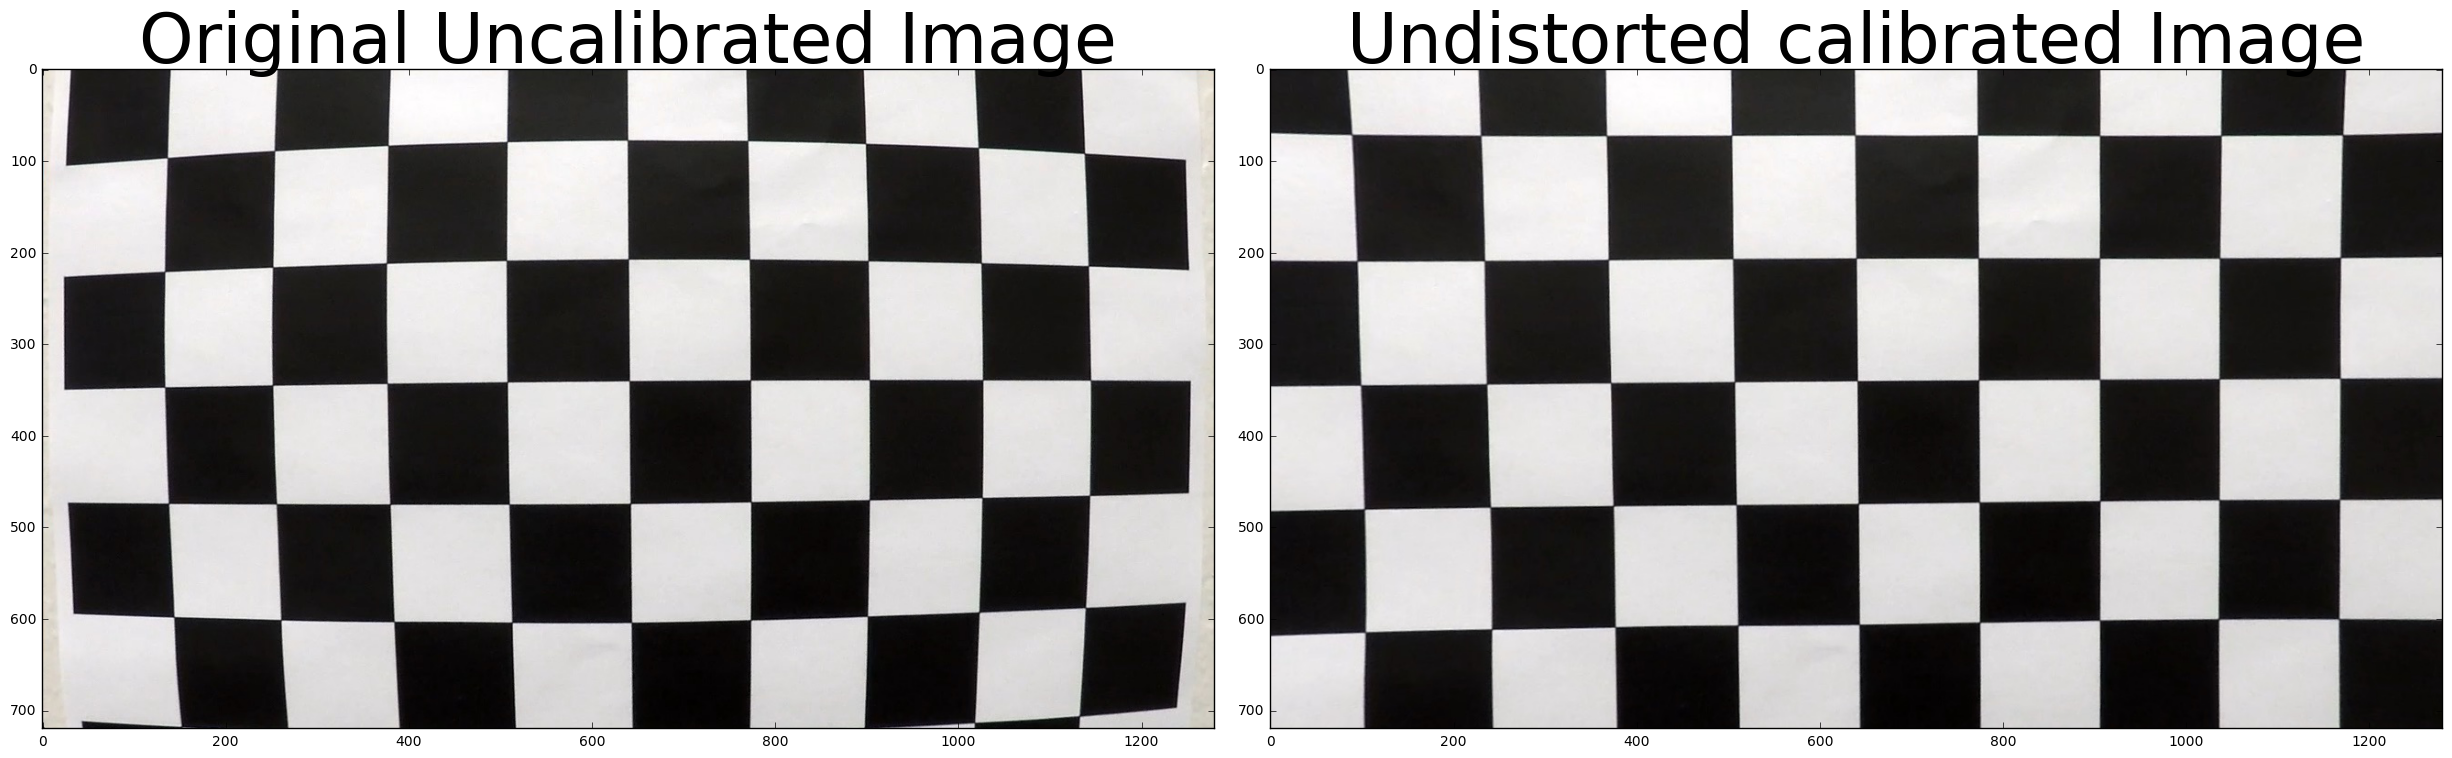

In [4]:
calibrationImage=r'C:\Users\Siddarth\Desktop\Udacity\CarND-Advanced-Lane-Lines-master\camera_cal\calibration1.jpg'
calimg=plt.imread(calibrationImage)

undistortedCalImg=cv2.undistort(calimg,mtx,dist,None, mtx)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(calimg)
ax1.set_title('Original Uncalibrated Image', fontsize=50)
ax2.imshow(undistortedCalImg)
ax2.set_title('Undistorted calibrated Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## CRITERIA 3: Provide an example of a distortion-corrected image.

## ANSWER : Below is the example of calibrated test image. The differece can be seen in the side trees and also on white car. 

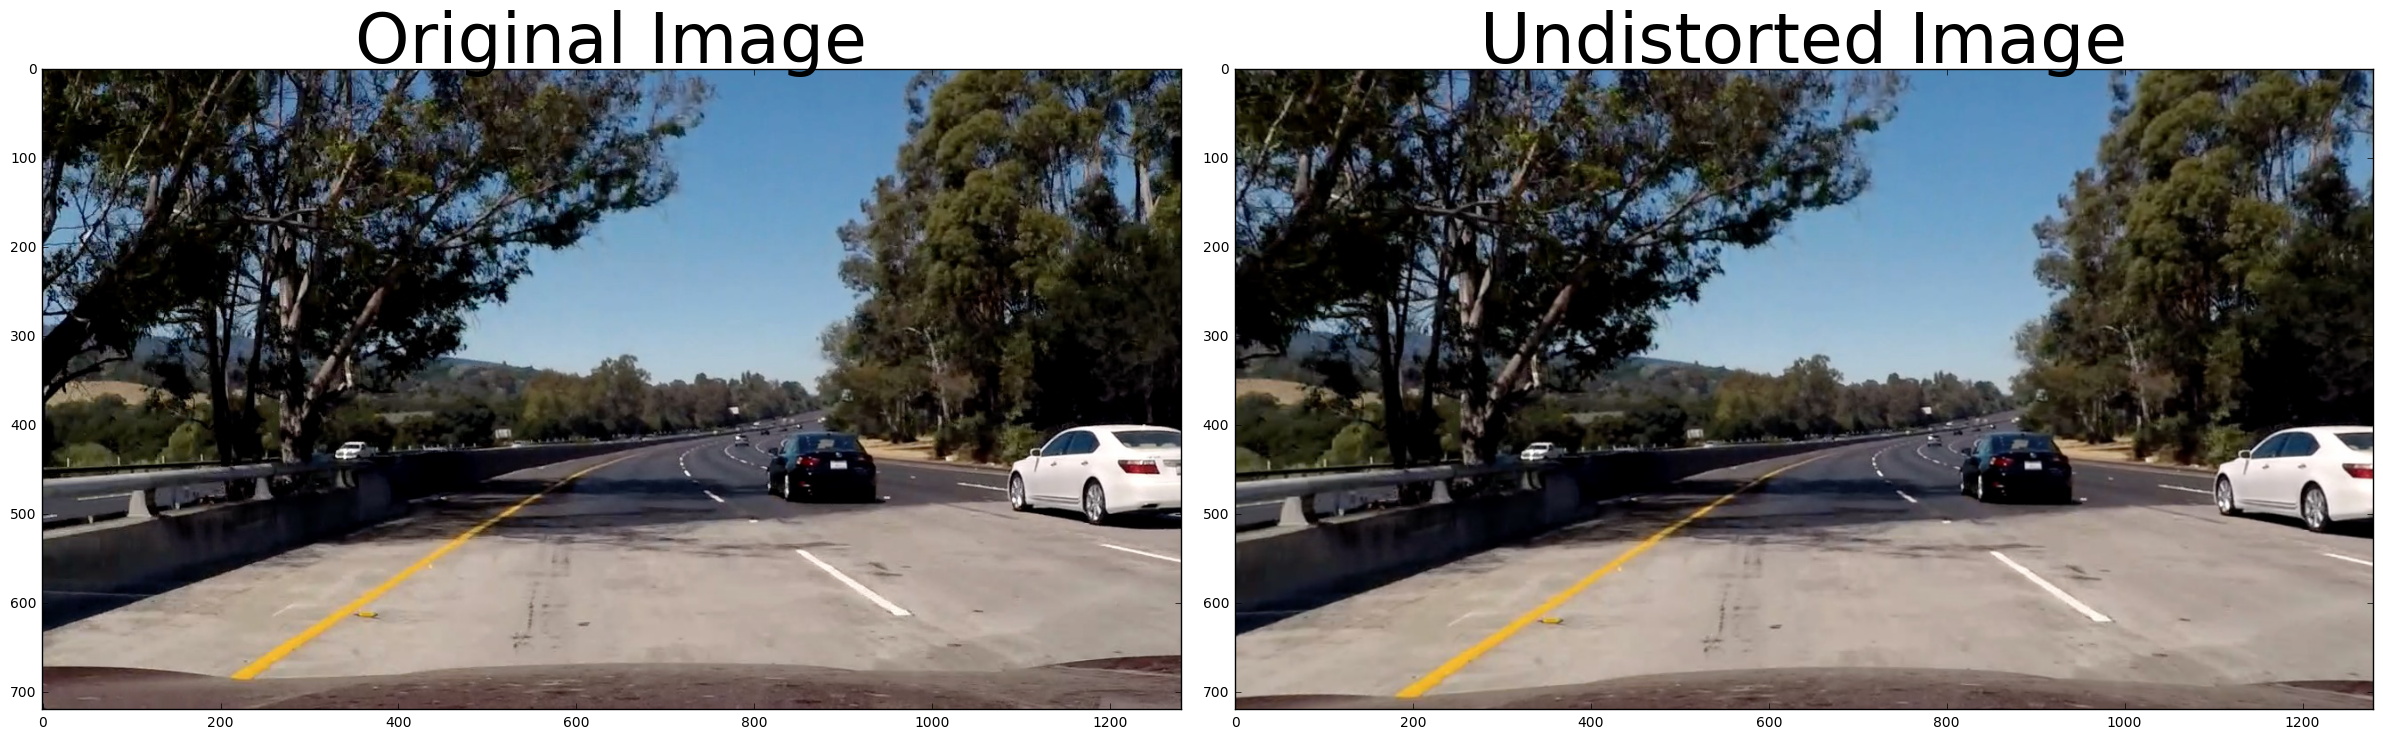

In [5]:
TestDistortion=r'C:\Users\Siddarth\Desktop\Udacity\CarND-Advanced-Lane-Lines-master\test_images\test5.jpg'
TestImgDistorted = mpimg.imread(TestDistortion)
TestImgUndistorted = cv2.undistort(TestImgDistorted, mtx, dist, None, mtx)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(TestImgDistorted)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(TestImgUndistorted)
ax2.set_title('Undistorted Image', fontsize=50)

## CRITERIA 4: Describe how (and identify where in your code) you used color transforms, gradients or other methods to create a thresholded binary image. Provide an example of a binary image result.

## ANSWER: Here below are functions to calculate the threshold images. This method does the robust job of finding the lanes in all colour and all lightingtypes. The method below would convert the image to binary thresholded image

In [7]:
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255, sobel_kernel=15):
    gray = img
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize= sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return binary_output

def mag_thresh(img, sobel_kernel=15, mag_thresh=(40, 100)):
    gray = img
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradmag = np.sqrt(sobelx**2+ sobely**2)
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = img
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

### This creates the thresholded Binary Image

def Binary_Threshold_Image(TestImage):
    
    TestImage = cv2.undistort(TestImage,mtx,dist,None,mtx)
    gray = cv2.cvtColor(TestImage, cv2.COLOR_RGB2GRAY)
    gradx = abs_sobel_thresh(gray, orient='x', thresh_min=45, thresh_max=90)
    mag_binary = mag_thresh(gray, sobel_kernel=15, mag_thresh=(80, 175))
    hls_binary = hls_select(TestImage,thresh=(100,250))
    combined_binary = np.zeros_like(gradx)
    combined_binary[((gradx == 1)) | (hls_binary == 1) | ((mag_binary == 1) )] = 1
    
    return combined_binary

### Creates Perspective transform

def Perspective_Transformed(image):
    imgsize=(image.shape[1],image.shape[0])
    warped=cv2.warpPerspective(image, M, imgsize,flags=cv2.INTER_LINEAR)
    return warped

def Binary_Transformed_Perspective(image):
    return Perspective_Transformed(Binary_Threshold_Image(image))

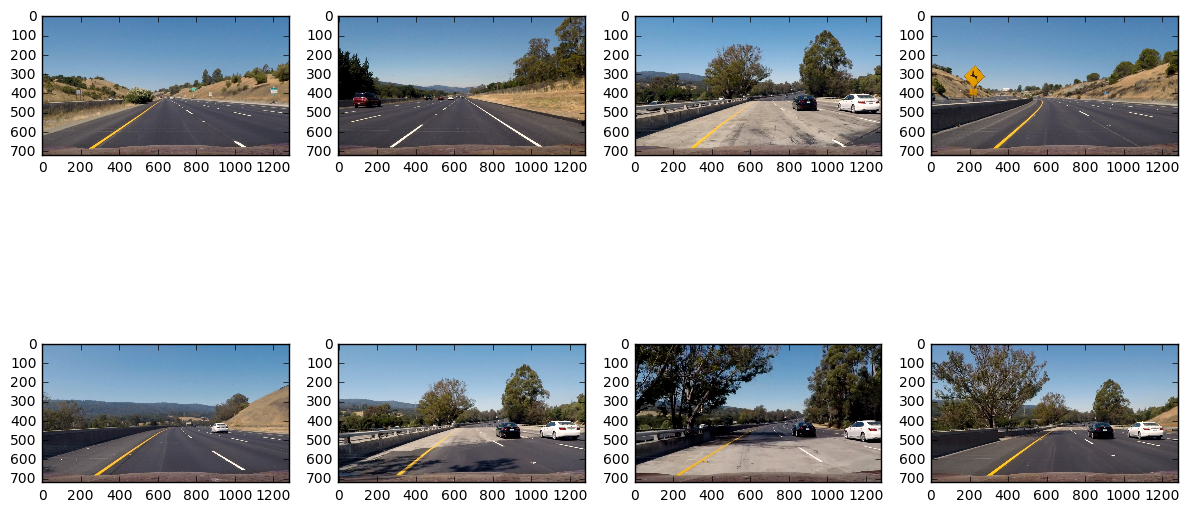

In [8]:
''' A Look a at all the test Images'''

testImgDir=r'C:\Users\Siddarth\Desktop\Udacity\CarND-Advanced-Lane-Lines-master\test_images'
f,ax = plt.subplots(2,4, figsize=(12,12))
i=0
j=0
for eachImage in os.listdir(testImgDir):
    link =  testImgDir+ '\\' +eachImage
    img = plt.imread(link)
    if i<4:
        ax[0][i].imshow(img)
        i+=1
    else:
        ax[1][j].imshow(img)
        j+=1
    plt.tight_layout()
    plt.subplots_adjust(wspace=None, hspace=None)
plt.show() # or display.display(plt.gcf()) if you prefer

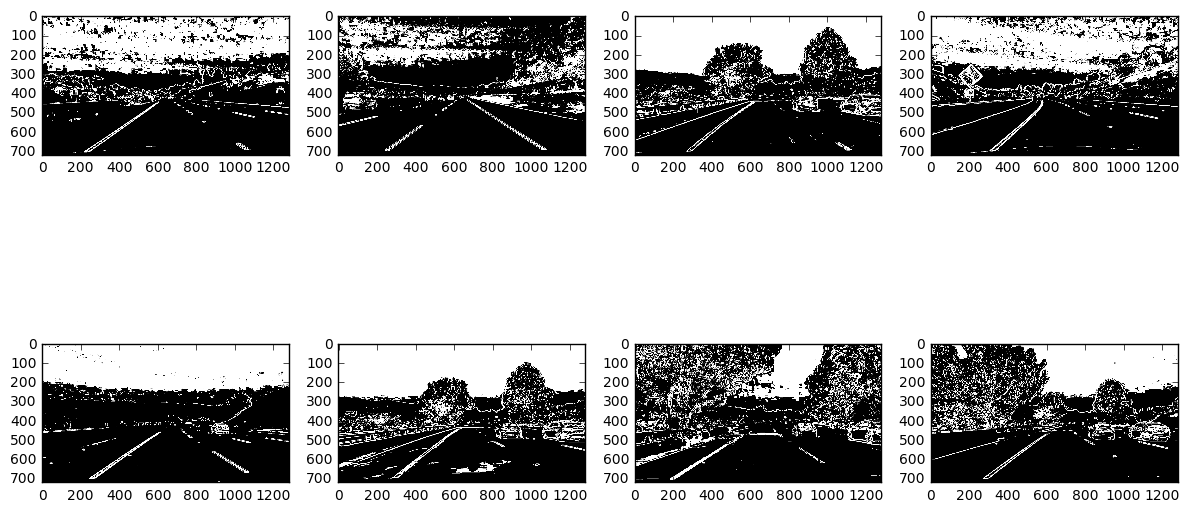

In [10]:
testImgDir=r'C:\Users\Siddarth\Desktop\Udacity\CarND-Advanced-Lane-Lines-master\test_images'
f,ax = plt.subplots(2,4, figsize=(12,12))
i=0
j=0
for eachImage in os.listdir(testImgDir):
    link =  testImgDir+ '\\' +eachImage
    TestImage = plt.imread(link)
    
    combined_binary = Binary_Threshold_Image(TestImage) 
    
    if i<4:
        ax[0][i].imshow(combined_binary, cmap='gray')
        i+=1
    else:
        ax[1][j].imshow(combined_binary, cmap='gray')
        j+=1
    plt.tight_layout()
    plt.subplots_adjust(wspace=None, hspace=None)
plt.show() 

## CRITERIA 5: Describe how (and identify where in your code) you performed a perspective transform and provide an example of a transformed image.

## ANSWER: The figure below was used for applying the perspective transform. The points chosen can be seen in the figure. It can be seen in the transformed Image that the lines are parallel

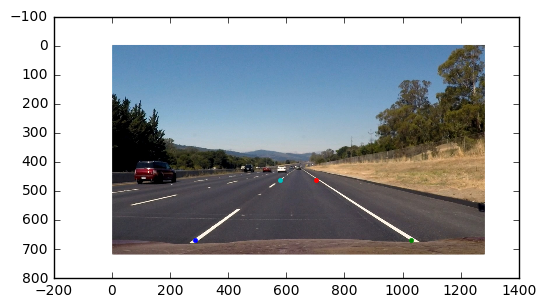

In [11]:
figstraightlines= r'C:/Users/Siddarth/Desktop/Udacity/CarND-Advanced-Lane-Lines-master/test_images/straight_lines2.jpg'
figstraightlinesimage = mpimg.imread(figstraightlines)
plt.imshow(figstraightlinesimage)
plt.plot(285,668,'.')
plt.plot(1029,668,'.')
plt.plot(703,460,'.')
plt.plot(580,460,'.')
imgsize=(figstraightlinesimage.shape[1],figstraightlinesimage.shape[0])

In [24]:
src=np.float32([[285,668],[1029,668],[703,460],[580,460]])
dst=np.float32([[278,719],[1029,719],[1035,5],[279,5]])

global M
global Minv
M = cv2.getPerspectiveTransform(src,dst)
Minv = cv2.getPerspectiveTransform(dst,src)

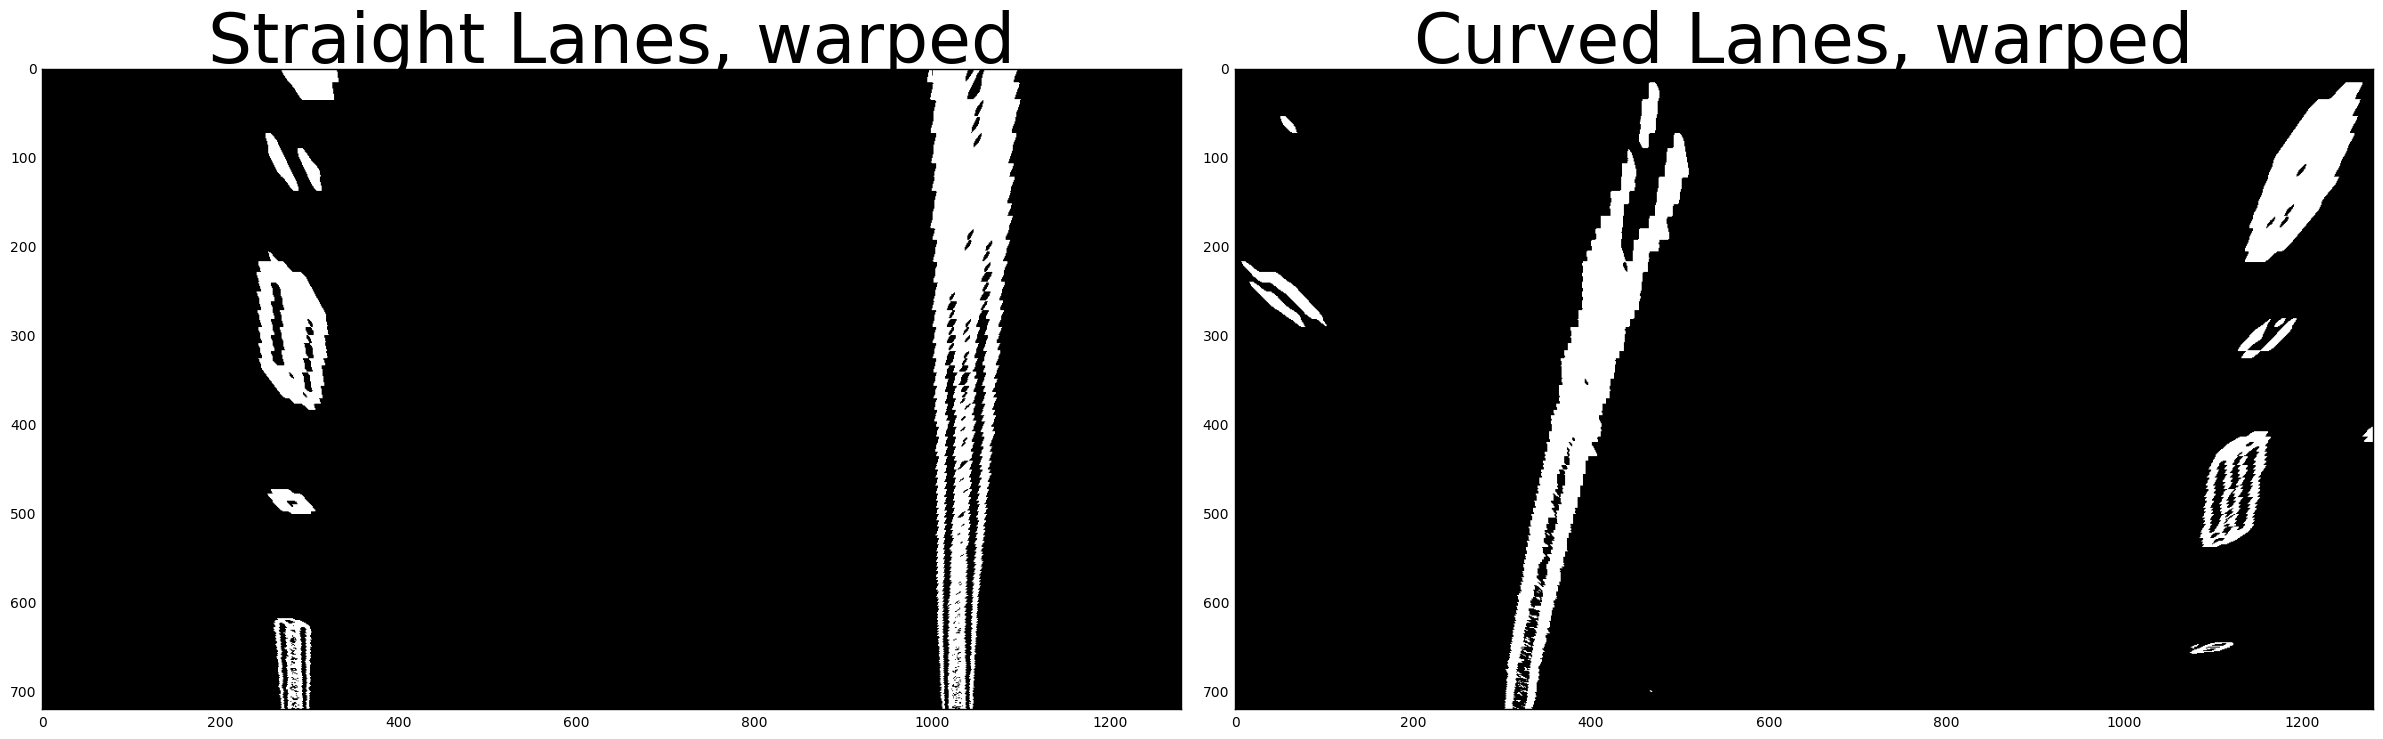

In [33]:
Straightwarped = Binary_Transformed_Perspective(figstraightlinesimage)

curvedRoad=r'C:/Users/Siddarth/Desktop/Udacity/CarND-Advanced-Lane-Lines-master/test_images/test6.jpg'
curvedIMG=plt.imread(curvedRoad)

binary_warped = Binary_Transformed_Perspective (curvedIMG)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(Straightwarped, cmap='gray')
ax1.set_title('Straight Lanes, warped',  fontsize=50)
ax2.imshow(binary_warped, cmap='gray')
ax2.set_title('Curved Lanes, warped', fontsize=50)


## CRITERIA 6: Describe how (and identify where in your code) you identified lane-line pixels and fit their positions with a polynomial?

## ANSWER : The Lanes were identified by the approach mentioned in the lectures.

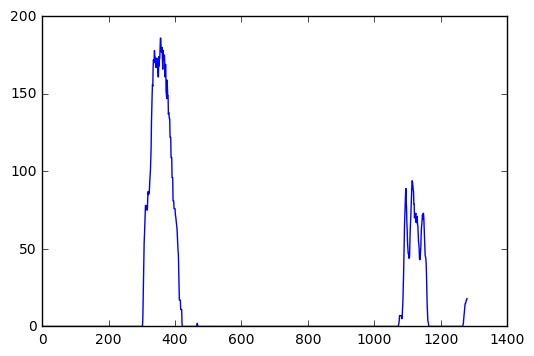

In [34]:
histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
plt.plot(histogram)

In [35]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

(720, 0)

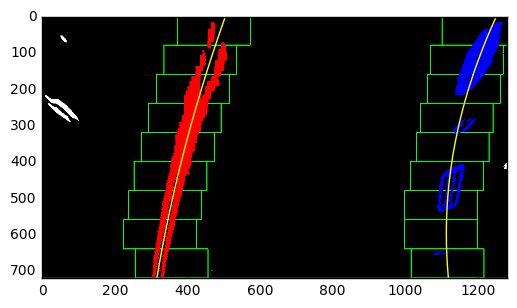

In [36]:
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [37]:
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

(720, 0)

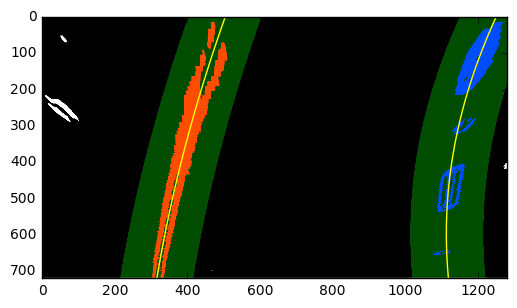

In [40]:
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

## CRITERIA 7: Describe how (and identify where in your code) you calculated the radius of curvature of the lane and the position of the vehicle with respect to center.
## ANSWER: By Using Polyfit and the formula for calculating the radius of curvature, the radius of curvature of the road was calculated

In [44]:
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])

ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')

1265.02732534 m 427.423191099 m


## CRITERIA 8: Provide an example image of your result plotted back down onto the road such that the lane area is identified clearly.

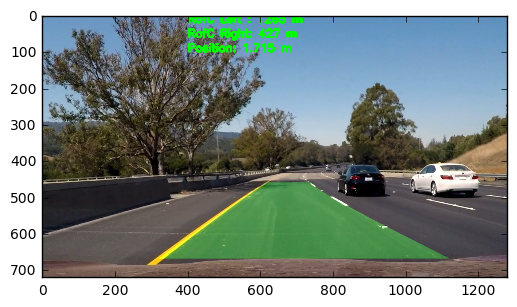

In [63]:
warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
image= curvedIMG
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (binary_warped.shape[1], binary_warped.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(curvedIMG, 1, newwarp, 0.3, 0)

Midpoint_image = binary_warped.shape[1]/2
leftLane_start, rightLane_start = left_fitx[-1], left_fitx[-1]
LaneMiddle = (rightLane_start- leftLane_start)/2
LaneMiddle=LaneMiddle+leftLane_start
vehiclePosition = (Midpoint_image - LaneMiddle)* xm_per_pix 
cv2.putText(result, "Position: %.3f m" %((vehiclePosition)) , (400,100), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 255, 0), 5)    
cv2.putText(result, "RofC Right: %d m" %(int(right_curverad)) , (400,60), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 255, 0), 5)    
cv2.putText(result, "RofC Left : %d m"%(int(left_curverad)) , (400, 20), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 255, 0),5)
plt.imshow(result)


## CRITERIA 9: Provide a link to your final video output. Your pipeline should perform reasonably well on the entire project video (wobbly lines are ok but no catastrophic failures that would cause the car to drive off the road!)

## ANSWER: Below is the code for creating the pipeline. The video is saved as Output_Video_Project.mp4

In [68]:
##All Helper functions

def FindLanes_First(binary_warped):
    orig = np.copy(binary_warped)
    ## Undistort the image
    #img = cv2.undistort(img, mtx, dist, None, mtx)
    #gradient_image, colored_binary = color_gradient_threshold(img)
    #binary_warped = Binary_Transformed_Perspective(img)
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_size = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_size
        win_y_high = binary_warped.shape[0] - window*window_size
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit,right_fit

def FindLanes_Next(binary_warped, left_fit, right_fit):
    #binary_warped = Binary_Transformed_Perspective(img)
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    return left_fit,right_fit

def FindLanes_Lines(binary_warped, left_fit, right_fit):
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    return left_fitx, right_fitx

def DrawLanes(img, binary_warped, left_fit, right_fit, left_curverad, right_curverad, vehiclePosition):
    fity = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Recast the x and y points into usable format for cv2.fillPoly()
    
    fit_leftx,fit_rightx= FindLanes_Lines(binary_warped, left_fit, right_fit)
    
    pts_left = np.array([np.transpose(np.vstack([fit_leftx, fity]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([fit_rightx, fity])))])
    pts = np.hstack((pts_left, pts_right))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    cv2.putText(result, "Position: %.3f m" %((vehiclePosition)) , (400,100), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 255, 0), 5)    
    cv2.putText(result, "RofC Right: %d m" %(int(right_curverad)) , (400,60), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 255, 0), 5)    
    cv2.putText(result, "RofC Left : %d m"%(int(left_curverad)) , (400, 20), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 255, 0),5)

    
    return result

def Calculate_parameters(binary_warped, left_fit, right_fit):
    
        #print(left_curverad, right_curverad)
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    

    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    
    fity=ploty
    
    leftx = left_fit[0]*fity**2 + left_fit[1]*fity + left_fit[2]
    rightx = right_fit[0]*fity**2 + right_fit[1]*fity + right_fit[2]
    
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    #left_fitx, right_fitx = FindLanes_Lines(binary_warped, left_fit, right_fit)
    
    Midpoint_image = binary_warped.shape[1]/2
    leftLane_start, rightLane_start = leftx[-1], rightx[-1]
    LaneMiddle = (rightLane_start - leftLane_start)/2
    LaneMiddle = LaneMiddle+leftLane_start
    vehiclePosition = (Midpoint_image - LaneMiddle)* xm_per_pix 

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])   
    
    return left_curverad, right_curverad, vehiclePosition

In [69]:
def counted(fn):
    def wrapper(*args, **kwargs):
        wrapper.called+= 1
        return fn(*args, **kwargs)
    wrapper.called= 0
    wrapper.__name__= fn.__name__
    return wrapper

left_fit_array=[]
right_fit_array=[]
def counted(fn):
    def wrapper(*args, **kwargs):
        wrapper.called+= 1
        return fn(*args, **kwargs)
    wrapper.called= 0
    wrapper.__name__= fn.__name__
    return wrapper

@counted
def pipeline1(img):
    binary_warped = Binary_Transformed_Perspective(img)
    if pipeline1.called == 1:        
        left_fit, right_fit = FindLanes_First(binary_warped)
        left_curverad, right_curverad, vehiclePosition = Calculate_parameters (binary_warped, left_fit, right_fit)
        draw_Image = DrawLanes(img, binary_warped, left_fit, right_fit, left_curverad, right_curverad, vehiclePosition)
        left_fit_array.append(left_fit)
        right_fit_array.append(right_fit)
        return draw_Image
    if pipeline1.called != 1: 
        left_fit=np.mean(left_fit_array[-10:],axis=0)
        right_fit= np.mean(right_fit_array[-10:], axis=0)
        left_fit, right_fit = FindLanes_Next(binary_warped, left_fit, right_fit)
        left_curverad, right_curverad, vehiclePosition = Calculate_parameters (binary_warped, left_fit, right_fit)
        left_fit_array.append(left_fit)
        right_fit_array.append(right_fit)
        draw_Image = DrawLanes(img, binary_warped, left_fit, right_fit, left_curverad, right_curverad, vehiclePosition)
        return draw_Image

In [71]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from IPython.display import display
input_video = VideoFileClip(r"C:\Users\Siddarth\Desktop\Udacity\CarND-Advanced-Lane-Lines-master\project_video.mp4")
output_video = input_video.fl_image(pipeline1) #NOTE: this function expects color images!!
output_video.write_videofile('Output_Video_Project_final.mp4')
#output_video.preview()
##get_ipython().magic('time output_clip.write_videofile(output, audio=False)')

[MoviePy] >>>> Building video Output_Video_Project_final.mp4
[MoviePy] Writing audio in Output_Video_Project_finalTEMP_MPY_wvf_snd.mp3




  0%|                                                 | 0/1112 [00:00<?, ?it/s]

  7%|██▉                                    | 82/1112 [00:00<00:01, 819.38it/s]

 18%|███████                               | 205/1112 [00:00<00:00, 910.42it/s]

 31%|███████████▋                         | 350/1112 [00:00<00:00, 1024.67it/s]

 42%|███████████████▌                     | 468/1112 [00:00<00:00, 1066.58it/s]

 54%|███████████████████▉                 | 601/1112 [00:00<00:00, 1110.97it/s]

 67%|████████████████████████▋            | 742/1112 [00:00<00:00, 1186.29it/s]

 78%|█████████████████████████████        | 872/1112 [00:00<00:00, 1218.09it/s]

 90%|████████████████████████████████▍   | 1001/1112 [00:00<00:00, 1233.77it/s]

100%|████████████████████████████████████| 1112/1112 [00:00<00:00, 1242.36it/s]

[MoviePy] Done.
[MoviePy] Writing video Output_Video_Project_final.mp4




  0%|                                                 | 0/1261 [00:00<?, ?it/s]

  0%|                                         | 1/1261 [00:00<05:00,  4.20it/s]

  0%|                                         | 2/1261 [00:00<04:49,  4.35it/s]

  0%|                                         | 3/1261 [00:00<04:39,  4.50it/s]

  0%|▏                                        | 4/1261 [00:00<04:41,  4.46it/s]

  0%|▏                                        | 5/1261 [00:01<04:29,  4.66it/s]

  0%|▏                                        | 6/1261 [00:01<04:21,  4.81it/s]

  1%|▏                                        | 7/1261 [00:01<04:14,  4.93it/s]

  1%|▎                                        | 8/1261 [00:01<04:12,  4.96it/s]

  1%|▎                                        | 9/1261 [00:01<04:12,  4.97it/s]

  1%|▎                                       | 10/1261 [00:02<04:09,  5.02it/s]

  1%|▎                                       | 11/1261 [00:02<04:07,  5.05it/s]

  1%|▍                    

[MoviePy] Done.
[MoviePy] >>>> Video ready: Output_Video_Project_final.mp4 



## CRITERIA 10: Briefly discuss any problems / issues you faced in your implementation of this project. Where will your pipeline likely fail? What could you do to make it more robust?

## ANSWER: The Pipelines works robustly under different weather conditions and shodows. It initially broke during shadows but then taking average of the lane lines(last 10) helps solve it.  There are few parts where there could be a lot of developments like finding a smooth radii of curvature. Currently its very fluctuating.

## Furthermore a way to make it computationally inexpensive should be thought of. Currently it takes 4-5 minutes for the video to be completed.